<a href="https://colab.research.google.com/github/Prabuddha747/Vehicle_Route_optimisation/blob/main/TSP_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import plotly.express as px
import osmnx as ox
import networkx as nx
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2

In [3]:
!pip install osmnx

In [4]:
import osmnx as ox
import networkx as nx
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2

In [5]:
!pip install ortools

In [6]:
from ortools.constraint_solver import pywrapcp

In [7]:
from ortools.constraint_solver import routing_enums_pb2

In [8]:
city = "London"
dtf=pd.read_csv('/data_stores.csv')
dtf=dtf[dtf["City"]==city][ ["City", "Street Address", "Latitude", "Longitude"]].reset_index(drop=True)
dtf=dtf.reset_index().rename(columns={"index":"id", "Latitude":"y", "Longitude":"x"})

print("total", len(dtf))
dtf.head(10)

total 216


,id,City,Street Address,y,x
0,0,London,265 Wharncliffe Rd North,42.99,-81.26
1,1,London,"1105 Wellington Rd., Store No. 122",42.93,-81.22
2,2,London,631 Commissioners Road East,42.96,-81.23
3,3,London,1442 Fanshawe Park Road,43.01,-81.34
4,4,London,"580 Fanshawe Park Road East, Unit 1, White Oak...",43.03,-81.26
5,5,London,1105 Wellington Road South,42.93,-81.22
6,6,London,1164 Highbury Ave N,43.01,-81.21
7,7,London,"160 Dundas St W, Corner Unit",42.98,-81.25
8,8,London,"1680 Richmond Street, L105A",43.03,-81.28
9,9,London,1291 Commissioners Road West,42.96,-81.33


In [9]:
data = dtf.copy()
data["color"]=''
data.loc[data['id']==0 , 'color'] = 'red'
data.loc[data['id']!=0 , 'color'] = 'black'
start=data[data["id"]==0][["y","x"]].values[0]
data.head(10)
print("starting point:" , start)

starting point: [ 42.99 -81.26]


In [10]:
map = folium.Map(location=start, tiles= "cartodbpositron", zoom_start=12)
data.apply(lambda row:
    folium.CircleMarker(
        location=[row["y"], row["x"]],
        color=row["color"], fill = True, radius=5).add_to(map), axis=1)

map

/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


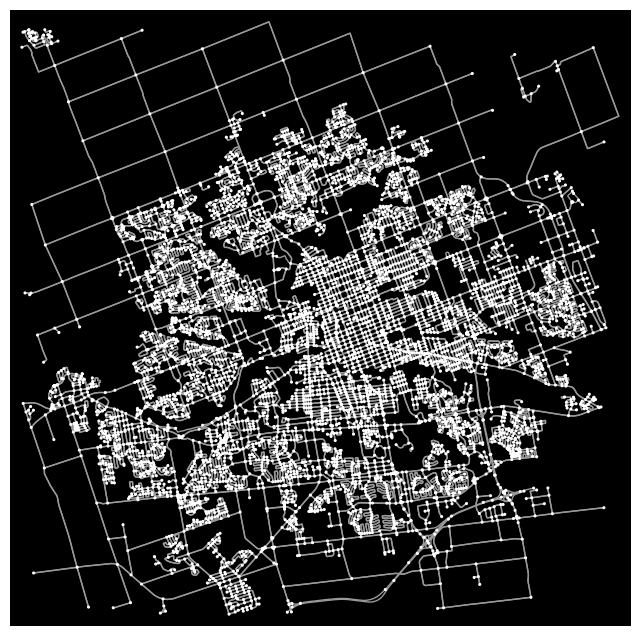

In [11]:
G=ox.graph_from_point(start, dist=10000, network_type="drive")
G=ox.add_edge_speeds(G)
G=ox.add_edge_travel_times(G)
fig,ax = ox.plot_graph(G, bgcolor="black", node_size=5 , node_color="white", figsize=(16,8))

In [12]:
start_node=ox.distance.nearest_nodes(G, start[1], start[0])
dtf["node"]=dtf[["y", "x"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
dtf=dtf.drop_duplicates("node", keep='first')
dtf.head()

<ipython-input-12-3f563add5754>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dtf["node"]=dtf[["y", "x"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
<ipython-input-12-3f563add5754>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dtf["node"]=dtf[["y", "x"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
<ipython-input-12-3f563add5754>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dtf["

,id,City,Street Address,y,x,node
0,0,London,265 Wharncliffe Rd North,42.99,-81.26,289796441
1,1,London,"1105 Wellington Rd., Store No. 122",42.93,-81.22,324811692
2,2,London,631 Commissioners Road East,42.96,-81.23,11756886360
3,3,London,1442 Fanshawe Park Road,43.01,-81.34,252974916
4,4,London,"580 Fanshawe Park Road East, Unit 1, White Oak...",43.03,-81.26,302754873


In [13]:
def f(a , b):
    try:
        d=nx.shortest_path_length(G, source=a, target=b, method='dijkstra', weight='travel_time')
    except:
        d=np.nan
    return d

distance_matrix=np.asarray([[f(a,b)for b in dtf["node"].tolist()] for a in dtf["node"].tolist()])
distance_matrix=pd.DataFrame(distance_matrix, columns=dtf["node"].values, index=dtf["node"].values)

distance_matrix.head()

,289796441,324811692,11756886360,252974916,302754873,305539079,347554420,4727288804,2600781784,1556562903,1606842225,295523341,313507828,1609033105,312125272,260890490,311486306,3058247625,347336428,7271237232
289796441,0.0,567.1,358.0,594.0,499.3,404.6,128.5,393.5,555.0,106.5,514.3,435.3,234.8,203.9,566.4,228.3,514.2,477.3,1037.3,1030.0
324811692,592.4,0.0,211.0,1099.2,950.2,712.7,458.8,874.4,736.8,494.5,403.0,887.3,674.2,403.8,675.9,790.9,120.0,982.5,1310.8,779.1
11756886360,381.4,209.9,0.0,912.8,739.2,578.9,247.8,663.4,550.4,283.5,410.5,700.9,463.2,192.8,575.3,594.7,239.4,796.1,1194.9,911.1
252974916,592.3,1096.1,914.6,0.0,429.2,850.2,705.4,323.4,481.8,665.4,725.4,355.7,500.7,768.0,1076.0,433.4,1025.0,174.5,1295.2,975.9
302754873,499.2,950.2,740.3,430.1,0.0,472.9,574.0,108.0,893.0,514.3,865.9,765.7,349.6,569.3,698.7,396.5,972.3,313.4,917.9,1387.1


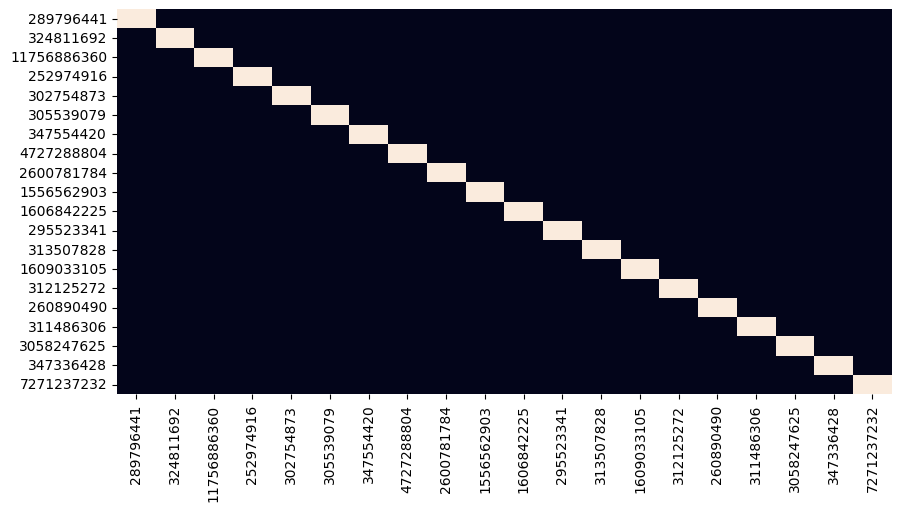

In [14]:
heatmap= distance_matrix.copy()
for col in heatmap.columns:
    heatmap[col]=heatmap[col].apply(lambda x:
         0.3 if pd.isnull(x) else
         (0.7 if np.isinf(x) else
          (0 if x!=0 else 1)) )

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(heatmap, vmin=0 , vmax=1 , cbar=False, ax=ax)
plt.show()

In [15]:
distance_matrix= distance_matrix.round()
distance_matrix=distance_matrix.fillna(0).astype('int') # Fill NaN values with 0 before converting to int
distance_matrix

,289796441,324811692,11756886360,252974916,302754873,305539079,347554420,4727288804,2600781784,1556562903,1606842225,295523341,313507828,1609033105,312125272,260890490,311486306,3058247625,347336428,7271237232
289796441,0,567,358,594,499,405,128,394,555,106,514,435,235,204,566,228,514,477,1037,1030
324811692,592,0,211,1099,950,713,459,874,737,494,403,887,674,404,676,791,120,982,1311,779
11756886360,381,210,0,913,739,579,248,663,550,284,410,701,463,193,575,595,239,796,1195,911
252974916,592,1096,915,0,429,850,705,323,482,665,725,356,501,768,1076,433,1025,174,1295,976
302754873,499,950,740,430,0,473,574,108,893,514,866,766,350,569,699,396,972,313,918,1387
305539079,405,641,582,847,470,0,437,525,895,377,868,768,417,411,308,561,744,730,690,1355
347554420,149,457,247,714,573,436,0,467,520,97,479,515,267,93,492,364,415,597,1067,995
4727288804,391,873,663,322,108,529,466,0,785,406,758,658,242,509,755,288,864,205,974,1279
2600781784,555,732,551,478,888,891,521,782,0,608,361,182,721,578,1003,565,661,633,1523,629
1556562903,169,493,283,668,513,377,97,407,604,0,564,536,207,129,491,338,496,551,1009,1079


In [16]:
drivers = 1
lst_nodes= dtf["node"].tolist()
print("start:", start_node, "total locations to visit", len(lst_nodes)-1, "drivers", drivers)

start: 289796441 total locations to visit 19 drivers 1


In [17]:
manager= pywrapcp.RoutingIndexManager(len(lst_nodes), drivers, lst_nodes.index(start_node))
model=pywrapcp.RoutingModel(manager)

In [18]:
def get_distance(from_index, to_index):
    return distance_matrix.iloc[from_index, to_index]

distance=model.RegisterTransitCallback(get_distance)
model.SetArcCostEvaluatorOfAllVehicles(distance)

parameters = pywrapcp.DefaultRoutingSearchParameters()
parameters.first_solution_strategy= (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

In [19]:
solution= model.SolveWithParameters(parameters)
Travelling_sales_person = 'dijkstra'
index=model.Start(0)

print('route for driver:')
route_idx, route_distance = [], 0

while not model.IsEnd(index):
    route_idx.append(manager.IndexToNode(index))
    previous_index=index
    index=solution.Value(model.NextVar(index))

    try:
        route_distance +=get_distance(previous_index, index)
    except:
        route_distance+=model.GetArcCostForVehicle(from_index=previous_index, to_index=index, vehicle=0)


print(route_idx)
print(f'Total distance:{round(route_distance/1000,2)}km')
print(f'Nodes visited: {len(route_idx)}')

route for driver:
[0, 6, 9, 13, 2, 1, 16, 10, 8, 11, 3, 17, 7, 4, 12, 15, 5, 14, 18, 19]
Total distance:6.7km
Nodes visited: 20


In [20]:
print("Route for driver (nodes):")
lst_route=[lst_nodes[i] for i in route_idx]
print(lst_route)

Route for driver (nodes):
[289796441, 347554420, 1556562903, 1609033105, 11756886360, 324811692, 311486306, 1606842225, 2600781784, 295523341, 252974916, 3058247625, 4727288804, 302754873, 313507828, 260890490, 305539079, 312125272, 347336428, 7271237232]


In [21]:
def get_path_between_nodes(lst_route):
    lst_paths=[]
    for i in range (len(lst_route)):
        try :
            a , b = lst_nodes[i], lst_nodes[i+1]
        except:
            break
        try:
            path=nx.shortest_path(G, source=a, target=b, method ='dijkstra', weight='travel_time')
            if len(path) > 1:
                lst_paths.append(path)
        except:
            continue
    return lst_paths

lst_paths= get_path_between_nodes(lst_route)

for path in lst_paths:
    ox.plot_route_folium(G, route=path, route_map=map, color="blue", weight=1)

map

<ipython-input-21-eb8784d65643>:19: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  ox.plot_route_folium(G, route=path, route_map=map, color="blue", weight=1)
<ipython-input-21-eb8784d65643>:19: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  ox.plot_route_folium(G, route=path, route_map=map, color="blue", weight=1)
<ipython-inp

In [22]:
def df_animation_multiple_path(G, lst_paths, parallel=True):
    df=pd.DataFrame()
    for path in lst_paths :
        lst_start, lst_end = [] , []
        start_x, start_y = [] , []
        end_x, end_y = [], []
        lst_length, lst_time = [], []

        for a , b in zip (path[:-1], path[1:]):
            lst_start.append(a)
            lst_end.append(b)
            lst_length.append(round(G.edges[(a,b,0)]['length']))
            lst_time.append(round(G.edges[(a,b,0)]['travel_time']))
            start_x.append(G.nodes[a]['x'])
            start_y.append(G.nodes[a]['y'])
            end_x.append(G.nodes[b]['x'])
            end_y.append(G.nodes[b]['y'])

        tmp=pd.DataFrame(list(zip(lst_start, lst_end, start_x, start_y, end_x, end_y, lst_length, lst_time)),
                         columns= ["start", "end", "start_x", "start_y", "end_x", "end_y", "length", "travel_time"])
        df=pd.concat([df,tmp], ignore_index=(not parallel))

    df=df.reset_index().rename(columns={"index":"id"})
    return df

In [23]:
df= pd.DataFrame()
tmp=df_animation_multiple_path(G, lst_paths, parallel=False)
df=pd.concat([df, tmp], axis=0)
first_node, last_node= lst_paths[0][0], lst_paths[-1][-1]

In [24]:
def df_animation_multiple_path(G, lst_paths, parallel=True):
    df=pd.DataFrame()
    for path in lst_paths :
        lst_start, lst_end = [] , []
        start_x, start_y = [] , []
        end_x, end_y = [], []
        lst_length, lst_time = [], []

        for a , b in zip (path[:-1], path[1:]):
            lst_start.append(a)
            lst_end.append(b)
            # Check if the edge exists and has the 'length' attribute
            if (a, b, 0) in G.edges and 'length' in G.edges[(a, b, 0)]:
                lst_length.append(round(G.edges[(a,b,0)]['length']))
            else:
                lst_length.append(None)  # or handle the missing edge/attribute differently

            # Check if the edge exists and has the 'travel_time' attribute
            if (a, b, 0) in G.edges and 'travel_time' in G.edges[(a, b, 0)]:
                lst_time.append(round(G.edges[(a,b,0)]['travel_time']))
            else:
                lst_time.append(None)  # or handle the missing edge/attribute differently

            start_x.append(G.nodes[a]['x'])
            start_y.append(G.nodes[a]['y'])
            end_x.append(G.nodes[b]['x'])
            end_y.append(G.nodes[b]['y'])

        tmp=pd.DataFrame(list(zip(lst_start, lst_end, start_x, start_y, end_x, end_y, lst_length, lst_time)),
                         columns= ["start", "end", "start_x", "start_y", "end_x", "end_y", "length", "travel_time"])
        df=pd.concat([df,tmp], ignore_index=(not parallel))

    df=df.reset_index().rename(columns={"index":"id"})
    return df

In [25]:
df_start= df[df["start"]== first_node]
df_end=df[df["end"]== last_node]

fig=px.scatter_mapbox(data_frame=df, lon="start_x", lat="start_y", zoom=11, width=1000, height=900, animation_frame="id",mapbox_style="carto-positron")

fig.data[0].marker={"size":12}

fig.add_trace(px.scatter_mapbox(data_frame=dtf, lon="x", lat="y").data[0])
fig.data[1].marker={"size":10, "color":"black"}

fig.add_trace(px.scatter_mapbox(data_frame=df_start, lon="start_x", lat="start_y").data[0])
fig.data[2].marker={"size":15, "color":"red"}

fig.add_trace(px.scatter_mapbox(data_frame=df_end, lon="start_x", lat="start_y").data[0])
fig.data[3].marker={"size":15, "color":"black"}

fig.add_trace(px.line_mapbox(data_frame=df, lon="start_x", lat="start_y").data[0])

fig